Importing Required datasets

In [1]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.5 MB/s 


In [2]:
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
import sklearn
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
import os
import random
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from math import log
from sklearn import svm
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import heapq
from stellargraph.mapper import CorruptedGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, DeepGraphInfomax
import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers, callbacks

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


loading the dataset into a dataframe

In [3]:
with open("data.json") as f:
    content = f.readlines()

df = [eval(c) for c in content]
df = pd.DataFrame(df)

df.drop(['article_link'],axis=1)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
1495,seasonal depression to take over for chronic d...,1
1496,6 older celebs who stole the show at the golde...,0
1497,"thank you, america",0
1498,man wearing sunglasses upside down on back of ...,1


Preprocessing the dataset 

In [4]:
def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [5]:
clean_data=df['headline'].apply(message_cleaning)

In [6]:
vectorizer = CountVectorizer(analyzer = message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(clean_data)

In [7]:
list1=[]
for i in clean_data:
  new=" ".join(i)
  new=new.lower()
  list1.append(new)
df['headline']=list1

In [8]:
indices=[i for i in range(1500)]

Finding the tf-idf of the headlines

In [9]:
tfidf=TfidfVectorizer()
result=tfidf.fit_transform(list1)
df1=pd.DataFrame(result.toarray(),columns=tfidf.get_feature_names_out())

In [10]:
df1.insert(0,"node_id",indices)

In [11]:
df1 = df1.set_index("node_id")

Calculating the cosine similarity and building the graphs

In [12]:
i=0
source=[]
target=[]
weight=[]
label = []
while(i!=1500):
  l1=cosine_similarity(result,result[i])
  l2=np.array(l1)
  l3=l1.tolist()
  ind=heapq.nlargest(100,range(len(l2)),l2.take)
  for j in ind:
    source.append(i)
    target.append(j)
    weight.append(l3[j][0])
    label.append(df['is_sarcastic'][i])
  i=i+1

In [13]:
edges = pd.DataFrame(
    {"source": source, "target": target, "weight":weight}
)

In [14]:
labels = []
for i in range(1500):
  labels.append(df['is_sarcastic'][i])

In [15]:
df1['is_sarcastic']=labels

In [16]:
graph = sg.StellarGraph(df1, edges)

In [17]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 1500, Edges: 150000

 Node types:
  default: [1500]
    Features: float32 vector, length 5468
    Edge types: default-default->default

 Edge types:
    default-default->default: [150000]
        Weights: range=[0, 1], mean=0.0419053, std=0.109042
        Features: none


Data Generator

In [18]:
fullbatch_generator = FullBatchNodeGenerator(graph)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(graph.nodes())

Using GCN (local pooling) filters...


Model pretraining with Deep Graph Infomax

In [19]:
def make_gcn_model():
    # function because we want to create a second one with the same parameters later
    return GCN(
        layer_sizes=[20, 20],
        activations=["sigmoid", "sigmoid"],
        generator=fullbatch_generator,
        dropout=0.6,
    )


pretrained_gcn_model = make_gcn_model()

In [20]:
infomax = DeepGraphInfomax(pretrained_gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

dgi_model = Model(inputs=x_in, outputs=x_out)
dgi_model.compile(
    loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=optimizers.Adam(learning_rate=1e-3)
)
#loss=losses.BinaryCrossentropy() - sus

In [21]:
epochs = 100

In [22]:
dgi_es = callbacks.EarlyStopping(monitor="loss", patience=100, restore_best_weights=True)
dgi_history = dgi_model.fit(gen, epochs=epochs, verbose=2, callbacks=[dgi_es])

Epoch 1/100
1/1 - 7s - loss: 1.1101 - 7s/epoch - 7s/step
Epoch 2/100
1/1 - 2s - loss: 1.0559 - 2s/epoch - 2s/step
Epoch 3/100
1/1 - 2s - loss: 1.0138 - 2s/epoch - 2s/step
Epoch 4/100
1/1 - 3s - loss: 0.9629 - 3s/epoch - 3s/step
Epoch 5/100
1/1 - 2s - loss: 0.9260 - 2s/epoch - 2s/step
Epoch 6/100
1/1 - 2s - loss: 0.8835 - 2s/epoch - 2s/step
Epoch 7/100
1/1 - 2s - loss: 0.8479 - 2s/epoch - 2s/step
Epoch 8/100
1/1 - 2s - loss: 0.8138 - 2s/epoch - 2s/step
Epoch 9/100
1/1 - 2s - loss: 0.7895 - 2s/epoch - 2s/step
Epoch 10/100
1/1 - 2s - loss: 0.7591 - 2s/epoch - 2s/step
Epoch 11/100
1/1 - 1s - loss: 0.7377 - 1s/epoch - 1s/step
Epoch 12/100
1/1 - 1s - loss: 0.7198 - 1s/epoch - 1s/step
Epoch 13/100
1/1 - 1s - loss: 0.7124 - 1s/epoch - 1s/step
Epoch 14/100
1/1 - 1s - loss: 0.7014 - 1s/epoch - 1s/step
Epoch 15/100
1/1 - 1s - loss: 0.6987 - 1s/epoch - 1s/step
Epoch 16/100
1/1 - 1s - loss: 0.6928 - 1s/epoch - 1s/step
Epoch 17/100
1/1 - 1s - loss: 0.6957 - 1s/epoch - 1s/step
Epoch 18/100
1/1 - 1s -

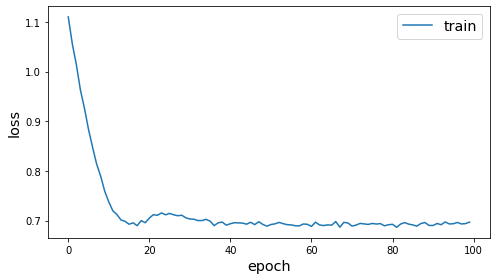

In [23]:
sg.utils.plot_history(dgi_history)  

In [24]:
node_classes=df1['is_sarcastic']

In [25]:
node_classes.value_counts().to_frame()

,is_sarcastic
0,843
1,657


Model Without Pretraining

In [26]:
train_classes, test_classes = model_selection.train_test_split(
    node_classes, train_size=50, stratify=node_classes
)
val_classes, test_classes = model_selection.train_test_split(
    test_classes, train_size=750, stratify=test_classes
)

In [27]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_classes)
val_targets = target_encoding.transform(val_classes)
test_targets = target_encoding.transform(test_classes)

In [28]:
test_gen = fullbatch_generator.flow(test_classes.index, test_targets)
train_gen = fullbatch_generator.flow(train_classes.index, train_targets)
val_gen = fullbatch_generator.flow(val_classes.index, val_targets)

In [29]:
pretrained_x_in, pretrained_x_out = pretrained_gcn_model.in_out_tensors()

pretrained_predictions = tf.keras.layers.Dense(
    units=train_targets.shape[1], activation="sigmoid"
)(pretrained_x_out)

In [30]:
pretrained_model = Model(inputs=pretrained_x_in, outputs=pretrained_predictions)
pretrained_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["acc"],
)

In [31]:
prediction_es = callbacks.EarlyStopping(
    monitor="val_acc", patience=100, restore_best_weights=True
)

In [32]:
pretrained_history = pretrained_model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    validation_data=val_gen,
    callbacks=[prediction_es],
)

Epoch 1/100
1/1 - 3s - loss: 0.7671 - acc: 0.4400 - val_loss: 0.7312 - val_acc: 0.4373 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 1s - loss: 0.7290 - acc: 0.4400 - val_loss: 0.7055 - val_acc: 0.4587 - 1s/epoch - 1s/step
Epoch 3/100
1/1 - 1s - loss: 0.7033 - acc: 0.4400 - val_loss: 0.6909 - val_acc: 0.5013 - 1s/epoch - 1s/step
Epoch 4/100
1/1 - 1s - loss: 0.6892 - acc: 0.5600 - val_loss: 0.6858 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 5/100
1/1 - 1s - loss: 0.6814 - acc: 0.5600 - val_loss: 0.6876 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 6/100
1/1 - 1s - loss: 0.6823 - acc: 0.5600 - val_loss: 0.6928 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 7/100
1/1 - 1s - loss: 0.6902 - acc: 0.5600 - val_loss: 0.6981 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 8/100
1/1 - 1s - loss: 0.6950 - acc: 0.5600 - val_loss: 0.7014 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 9/100
1/1 - 1s - loss: 0.6977 - acc: 0.5600 - val_loss: 0.7021 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 10/100
1/1 - 1s - loss

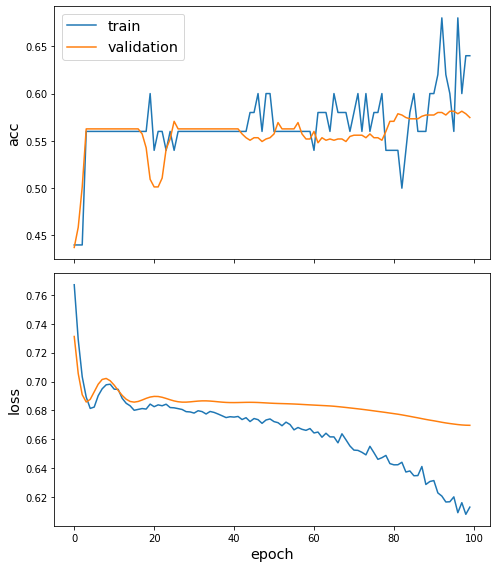

In [33]:
sg.utils.plot_history(pretrained_history)

In [34]:
pretrained_test_metrics = dict(
    zip(pretrained_model.metrics_names, pretrained_model.evaluate(test_gen))
)
print(pretrained_test_metrics)

1/1 [==============================] - 1s 702ms/step - loss: 0.6707 - acc: 0.5729
{'loss': 0.6706563830375671, 'acc': 0.572857141494751}


In [35]:
direct_gcn_model = make_gcn_model()
direct_x_in, direct_x_out = direct_gcn_model.in_out_tensors()
direct_predictions = tf.keras.layers.Dense(
    units=train_targets.shape[1], activation="sigmoid"
)(direct_x_out)

In [36]:
direct_model = Model(inputs=direct_x_in, outputs=direct_predictions)
direct_model.compile(
    optimizer=optimizers.Adam(lr=0.01), loss=losses.BinaryCrossentropy(), metrics=["acc"],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
direct_history = direct_model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    validation_data=val_gen,
    callbacks=[prediction_es],
)

Epoch 1/100
1/1 - 3s - loss: 0.7020 - acc: 0.5600 - val_loss: 0.6884 - val_acc: 0.5627 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 2s - loss: 0.6866 - acc: 0.5600 - val_loss: 0.6848 - val_acc: 0.5627 - 2s/epoch - 2s/step
Epoch 3/100
1/1 - 1s - loss: 0.6856 - acc: 0.5600 - val_loss: 0.6884 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 4/100
1/1 - 2s - loss: 0.6890 - acc: 0.5600 - val_loss: 0.6908 - val_acc: 0.5627 - 2s/epoch - 2s/step
Epoch 5/100
1/1 - 2s - loss: 0.6896 - acc: 0.5600 - val_loss: 0.6898 - val_acc: 0.5627 - 2s/epoch - 2s/step
Epoch 6/100
1/1 - 2s - loss: 0.6893 - acc: 0.5600 - val_loss: 0.6871 - val_acc: 0.5627 - 2s/epoch - 2s/step
Epoch 7/100
1/1 - 1s - loss: 0.6841 - acc: 0.5600 - val_loss: 0.6850 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 8/100
1/1 - 1s - loss: 0.6851 - acc: 0.5600 - val_loss: 0.6844 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 9/100
1/1 - 1s - loss: 0.6825 - acc: 0.5600 - val_loss: 0.6851 - val_acc: 0.5627 - 1s/epoch - 1s/step
Epoch 10/100
1/1 - 2s - loss

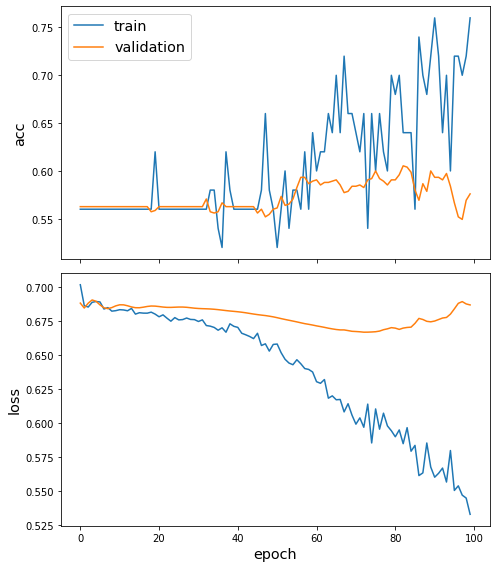

In [38]:
sg.utils.plot_history(direct_history)

In [39]:
direct_test_metrics = dict(
    zip(direct_model.metrics_names, direct_model.evaluate(test_gen))
)
print(direct_test_metrics)

1/1 [==============================] - 1s 1s/step - loss: 0.6733 - acc: 0.5800
{'loss': 0.6733227372169495, 'acc': 0.5799999833106995}


Results

In [40]:
pd.DataFrame(
    [pretrained_test_metrics, direct_test_metrics],
    index=["with DGI pre-training", "without pre-training"],
).round(3)

,loss,acc
with DGI pre-training,0.671,0.573
without pre-training,0.673,0.580


In [56]:
dir_hist=direct_model.evaluate(test_gen)
pre_hist=pretrained_model.evaluate(test_gen)

1/1 [==============================] - 1s 611ms/step - loss: 0.6707 - acc: 0.5729


In [57]:
print('testing acc for direct={0:.2%}'.format(dir_hist[1]))
print('testing acc for pretrained={0:.2%}'.format(pre_hist[1]))

testing acc for direct=58.00%
testing acc for pretrained=57.29%


In [58]:
dir_hist1=direct_model.evaluate(val_gen)
pre_hist1=pretrained_model.evaluate(val_gen)

1/1 [==============================] - 1s 615ms/step - loss: 0.6697 - acc: 0.5747


In [59]:
print('validation acc for direct={0:.2%}'.format(dir_hist1[1]))
print('validation acc for pretrained={0:.2%}'.format(pre_hist1[1]))

validation acc for direct=57.60%
validation acc for pretrained=57.47%
